In [1]:
import cmaps

import pandas as pd 
import numpy as np
import xarray as xr

import cftime 
import nc_time_axis

from shapely import geometry
from scipy import signal, stats

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import seaborn as sns 
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
                   
from src import precip, utils, nino34, dmi

from concurrent.futures import ProcessPoolExecutor

import random
random.seed(541415)

%load_ext autoreload
%autoreload 2

In [2]:
num_samples=10000

In [3]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [4]:
N=13

def process_member(ens):
    print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.Nino34.nc")
    sst_anm = utils.get_model_sst_anomalies(sst_da, detrend=False)
    
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = utils.get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)

    print("Getting running correlation...")
    corr_lead = utils.get_running_corr(precip_anm, sst_anm.shift(time=1), window=N)
    
    return (corr_lead, precip_anm, sst_anm)
    
def main(members):
    lead_correlations = []
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        corr_lead, precip_anm, sst_anm = result
        lead_correlations.append(corr_lead)
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return lead_correlations, all_precips, all_ssts
  
lead_correlations, all_precips, all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009
Processing LE2-1181.010
Processing LE2-1231.002Processing LE2-1191.010Processing LE2-1231.001


Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.007Processing LE2-1231.008Processing LE2-1231.005Processing LE2-1231.006



Processing LE2-1231.009
Processing LE2-1231.010
Processing LE2-1231.011
Processing LE2-1231.012
Processing LE2-1231.013
Processing LE2-1231.014
Processing LE2-1231.015
Processing LE2-1231.016
Processing LE2-1231.017Processing LE2-1231.018Processing LE2-1231.019


Processing LE2-1231.020
Processing LE2-1251.001
Processing LE2-1

In [5]:
def process_member(ens):
    print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc")
    return sst_da
    
def main(members):
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        sst_anm = result
        all_ssts.append(sst_anm)
    return all_ssts

global_all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009
Processing LE2-1181.010
Processing LE2-1231.002Processing LE2-1191.010

Processing LE2-1231.001
Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.010Processing LE2-1231.011Processing LE2-1231.012


Processing LE2-1231.013
Processing LE2-1231.014
Processing LE2-1231.015Processing LE2-1231.016Processing LE2-1231.017


Processing LE2-1231.018Processing LE2-1231.019

Processing LE2-1231.020
Processing LE2-1251.001
Processing LE2-1

In [6]:
# Figure 3a
lead_correlations_da = xr.concat(lead_correlations, dim='ensemble')
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble')
global_ssts_ds = xr.concat(global_all_ssts, dim='ensemble')

# tropial west Indian Ocean: 40–80°E, -5°S–5°N)
indian_ocean = global_ssts_ds.sel(
    lat=slice(-5,5), lon=slice(40,80)

)

# Central: 100–125°E, -20°S–20°N)
indo_pacific = global_ssts_ds.sel(
    lat=slice(-20,20), lon=slice(100,125)

)

#Western Pacific: 5S-5N and 140E-180W.
west_pacific = global_ssts_ds.sel(
    lat=slice(-5,5), lon=slice(140,180)

)

indian_ocean = utils.calc_cos_wmean(indian_ocean)
indo_pacific = utils.calc_cos_wmean(indo_pacific)
west_pacific = utils.calc_cos_wmean(west_pacific)

In [8]:
from src import dmi, iob
iod = dmi.get_IOD_anm_timeseries(global_ssts_ds, detrend=False,
                          base_start='1951', base_end='2015',
                          filtered=True)
nino34_pacific = global_ssts_ds.sel(
    lat=slice(-5,5), lon=slice(190,240)

)
nino34_pacific = utils.calc_cos_wmean(nino34_pacific)

iob = iob.get_IOB_anm_timeseries(global_ssts_ds, detrend=False,
                          base_start='1951', base_end='2015',
                          filtered=True)

In [9]:
# Randomly select 10,000 13-year timeseries between 1900-2014
# (should be the same as Fig 2 because of the same random seed)
def get_df(year_start, year_end, start_idx, end_idx):
    
    # Figure 3a

    years = list(range(year_start, year_end))

    precips_da_1900_2014 = precips_da.sel(time=slice(str(year_start), str(year_end)))
    ssts_da_1900_2014 = ssts_da.sel(time=slice(str(year_start), str(year_end)))
    indian_ocean_da_1900_2014 = indian_ocean['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    indo_pacific_da_1900_2014 = indo_pacific['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    west_pacific_da_1900_2014 = west_pacific['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    nino34_pacific_da_1900_2014 = nino34_pacific['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    iod_da_1900_2014 = iod['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))

    precips_da_1900_2014 = utils.detrend_array(precips_da_1900_2014, dim='time', deg=1)
    indian_ocean_da_1900_2014 = utils.detrend_array(indian_ocean_da_1900_2014, dim='time', deg=1)
    indo_pacific_da_1900_2014 = utils.detrend_array(indo_pacific_da_1900_2014, dim='time', deg=1)
    west_pacific_da_1900_2014 = utils.detrend_array(west_pacific_da_1900_2014, dim='time', deg=1)
    nino34_pacific_da_1900_2014 = utils.detrend_array(nino34_pacific_da_1900_2014, dim='time', deg=1)
    iod_da_1900_2014 = utils.detrend_array(iod_da_1900_2014, dim='time', deg=1)

    random_members = []
    random_starts = []

    precips = []
    indian_oceans = []
    indo_pacifics = []
    west_pacifics = []
    nino34_pacifics = []
    iods = []

    for _ in range(num_samples):

        # Generate a random time index (0=1900, 102=2014-1900-13+1)
        random_time = random.randint(start_idx, end_idx)

        # Generate a random member index (between 0 and 100)
        random_member = random.randint(0, 99)

        pre = precips_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        st = ssts_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))


        r1 = indian_ocean_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        r2 = indo_pacific_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        r3 = west_pacific_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))

        r4 = nino34_pacific_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        r5 = iod_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))

        indian_oceans.append(r1.mean(dim='time').values.item())
        indo_pacifics.append(r2.mean(dim='time').values.item())
        west_pacifics.append(r3.mean(dim='time').values.item())
        
        precips.append(pre.mean(dim='time').values.item())
        nino34_pacifics.append(r4.mean(dim='time').values.item())
        iods.append(r5.mean(dim='time').values.item())
        
        random_members.append(random_member)
        random_starts.append(years[random_time])

    df = pd.DataFrame({'Members': random_members, 'Years': random_starts, 'Indian_Ocean': indian_oceans, 'Indo_Pacific': indo_pacifics, 'West_Pacific': west_pacifics, 'Nino34_Pacific':nino34_pacifics, 'IOD':iods, 'MSEA':precips})
    
    return df

In [10]:
df = get_df(1900, 2014, 0, 102)

In [11]:
def get_df_ENSO_IOD(df, year_start, year_end, start_idx, end_idx):
    
    # Figure 3a
    el_nino_threshold = 0.5
    la_nina_threshold = -0.5

    years = list(range(year_start, year_end))
    nino34_pacific_da_1900_2014 = nino34_pacific['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    nino34_pacific_da_1900_2014 = utils.detrend_array(nino34_pacific_da_1900_2014, dim='time', deg=1)
    nino34_pacific_da_1900_2014 = nino34_pacific_da_1900_2014.shift(time=1) # shift so that year 1900 refers to D(1899)JF(1900)

    random_members = []
    random_starts = []

    EN_frequency = []
    LN_frequency = []

    EN_years = []
    LN_years = []

    iod_da_1900_2014 = iod['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    iod_da_1900_2014 = utils.detrend_array(iod_da_1900_2014, dim='time', deg=1)
    iod_da_1900_2014 = iod_da_1900_2014.shift(time=1) # shift so that year 1900 refers to D(1899)JF(1900)

    pIOD_threshold = 0.5
    nIOD_threshold = -0.5

    pIOD_years_list = []
    nIOD_years_list = []

    pIOD_frequency = []
    nIOD_frequency = []

    #iob_da_1900_2014 = iob_da['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    #iob_da_1900_2014 = utils.detrend_array(iob_da_1900_2014, dim='time', deg=1)
    #  year 1900 refers to MAM(1900)

    #pIOB_threshold = 0.5
    #nIOB_threshold = -0.5

    #pIOB_frequency = []
    #nIOB_frequency = []

    for member, year in zip(df.Members, df.Years):

        # Generate a random time index (0=1900, 102=2014-1900-13+1)
        random_time = year

        # Generate a random member index (between 0 and 100)
        random_member = member

        nino34_clm = nino34_pacific_da_1900_2014.isel(ensemble=random_member).sel(time=slice(str(random_time),str(random_time+13)))
        nino34_anm = nino34_clm - df['Nino34_Pacific'].mean()
        
        iod_anm = iod_da_1900_2014.isel(ensemble=random_member).sel(time=slice(str(random_time),str(random_time+13)))
        #iob_anm = iob_da_1900_2014.isel(ensemble=random_member).sel(time=slice(str(random_time),str(random_time+13)))

        el_nino_years = nino34_anm.where(nino34_anm > el_nino_threshold, drop=True)
        la_nina_years = nino34_anm.where(nino34_anm < la_nina_threshold, drop=True)

        EN_years.append(el_nino_years)
        LN_years.append(la_nina_years)

        
        pIOD_years = iod_anm.where(iod_anm > pIOD_threshold, drop=True)
        nIOD_years = iod_anm.where(iod_anm < nIOD_threshold, drop=True)

        #pIOB_years = iob_anm.where(iob_anm > pIOB_threshold, drop=True)
        #nIOB_years = iob_anm.where(iob_anm < nIOB_threshold, drop=True)


        EN_frequency.append(el_nino_years.size)
        LN_frequency.append(la_nina_years.size)
        
        pIOD_frequency.append(pIOD_years.size)
        nIOD_frequency.append(nIOD_years.size)

        #pIOB_frequency.append(pIOB_years.size)
        #nIOB_frequency.append(nIOB_years.size)

        pIOD_years_list.append(pIOD_years)
        nIOD_years_list.append(nIOD_years)

        random_members.append(random_member)
        random_starts.append(random_time)

    df2 = pd.DataFrame({'Members': random_members, 'Years': random_starts, 
                        'EN_Frequency' : EN_frequency,  'LN_Frequency' : LN_frequency, 
                        'pIOD_Frequency' : pIOD_frequency,  'nIOD_Frequency' : nIOD_frequency,
                        'EN_years': EN_years, 'LN_years' : LN_years,
                        'pIOD_years': pIOD_years_list, 'nIOD_years': nIOD_years_list
                        })

                     
                       # 'pIOB_Frequency' : pIOB_frequency,  'nIOB_Frequency' : nIOB_frequency})
    
    return df2

In [12]:
df2 = get_df_ENSO_IOD(df, 1900, 2014, 0, 102)

In [13]:
df['EN_Frequency'] = df2['EN_Frequency']
df['LN_Frequency'] = df2['LN_Frequency']
df['pIOD_Frequency'] = df2['pIOD_Frequency']
df['nIOD_Frequency'] = df2['nIOD_Frequency']

df['Indian_Ocean_z'] = (df['Indian_Ocean']-df.Indian_Ocean.mean())/df.Indian_Ocean.std()
df['Indo_Pacific_z'] = (df['Indo_Pacific']-df.Indo_Pacific.mean())/df.Indo_Pacific.std()
df['West_Pacific_z'] = (df['West_Pacific']-df.West_Pacific.mean())/df.West_Pacific.std()


In [14]:
warm_threshold = 0.5
cool_threshold = -0.5

warm_Pattern = df[(df['Indo_Pacific_z']<=cool_threshold) & (df['Indian_Ocean_z']>=warm_threshold) & (df['West_Pacific_z']>=warm_threshold)]
cool_Pattern = df[(df['Indo_Pacific_z']>=warm_threshold) & (df['Indian_Ocean_z']<=cool_threshold) & (df['West_Pacific_z']<=cool_threshold)]


In [15]:
def plot_barplot(ax, variable1, variable2, label1, label2, x=np.array([0.2, 0.8]), width=0.20, loc='upper left'):
    # Define the numbers
    a = np.mean(warm_Pattern[f'{variable1}'])
    b = np.mean(warm_Pattern[f'{variable2}'])
    c = np.mean(cool_Pattern[f'{variable1}'])
    d = np.mean(cool_Pattern[f'{variable2}'])
    a_std = np.std(warm_Pattern[f'{variable1}'])
    b_std = np.std(warm_Pattern[f'{variable2}'])
    c_std = np.std(cool_Pattern[f'{variable1}'])
    d_std = np.std(cool_Pattern[f'{variable2}'])

    # Prepare the data and labels
    labels = ['+TTP', '-TTP']
    EN_values = [a, c]  
    LN_values = [b, d]  

    EN_std = [a_std, d_std]
    LN_std = [b_std, d_std]

    # Define the positions for the bars
    x = x
    width = width

    # Plot the bars with error bars
    bars1 = ax.bar(x - width/2, EN_values, width, yerr=EN_std, label=label1, color='tomato',  error_kw=dict(lw=0.5, capsize=3, capthick=0.5))
    bars2 = ax.bar(x + width/2, LN_values, width, yerr=LN_std, label=label2, color='dodgerblue', error_kw=dict(lw=0.5, capsize=3, capthick=0.5))
  
            
    ax.set_ylabel('Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)


    # Add value labels on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')    


In [16]:
# Randomly select 10,000 13-year timeseries between 1900-2014
# (should be the same as Fig 2 because of the same random seed)
def get_paired_data(year_start, year_end, start_idx, end_idx):
    
    # Figure 3a

    years = list(range(year_start, year_end))

    precips_da_1900_2014 = precips_da.sel(time=slice(str(year_start), str(year_end)))
    ssts_da_1900_2014 = ssts_da.sel(time=slice(str(year_start), str(year_end)))
    lead_correlations_da_1900_2014 = lead_correlations_da['corr'].sel(time=slice(str(year_start), str(year_end)))
    indian_ocean_da_1900_2014 = indian_ocean['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    indo_pacific_da_1900_2014 = indo_pacific['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))
    west_pacific_da_1900_2014 = west_pacific['SST'].isel(z_t=0, drop=True).sel(time=slice(str(year_start), str(year_end)))

    indian_ocean_da_1900_2014 = utils.detrend_array(indian_ocean_da_1900_2014, dim='time', deg=1)
    indo_pacific_da_1900_2014 = utils.detrend_array(indo_pacific_da_1900_2014, dim='time', deg=1)
    west_pacific_da_1900_2014 = utils.detrend_array(west_pacific_da_1900_2014, dim='time', deg=1)

    
    correlations = []
    random_members = []
    random_starts = []

    indian_oceans = []
    indo_pacifics = []
    west_pacifics = []

    for _ in range(num_samples):

        # Generate a random time index (0=1900, 102=2014-1900-13+1)
        random_time = random.randint(start_idx, end_idx)

        # Generate a random member index (between 0 and 100)
        random_member = random.randint(0, 99)

        pre = precips_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        st = ssts_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))

        corr = xr.corr(pre, st.shift(time=1), dim='time')

        r1 = indian_ocean_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        r2 = indo_pacific_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
        r3 = west_pacific_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))

        indian_oceans.append(r1.mean(dim='time').values.item())
        indo_pacifics.append(r2.mean(dim='time').values.item())
        west_pacifics.append(r3.mean(dim='time').values.item())
        
        correlations.append(corr.values.item())
        random_members.append(random_member)
        random_starts.append(years[random_time])

    df = pd.DataFrame({'Members': random_members, 'Years': random_starts, 'Correlations': correlations, 'Indian_Ocean': indian_oceans, 'Indo_Pacific': indo_pacifics, 'West_Pacific': west_pacifics})

    df['Indian_Ocean_z'] = (df['Indian_Ocean']-df.Indian_Ocean.mean())/df.Indian_Ocean.std()
    df['Indo_Pacific_z'] = (df['Indo_Pacific']-df.Indo_Pacific.mean())/df.Indo_Pacific.std()
    df['West_Pacific_z'] = (df['West_Pacific']-df.West_Pacific.mean())/df.West_Pacific.std()

    warm_threshold = 0.5
    cool_threshold = -0.5

    warm_Indian_Ocean = df[(df['Indian_Ocean_z']>=warm_threshold)] # & (np.abs(df['Indo_Pacific_z'])<=neutral_threshold) & (np.abs(df['West_Pacific_z'])<=neutral_threshold)]
    cool_Indian_Ocean = df[(df['Indian_Ocean_z']<=cool_threshold)] # & (np.abs(df['Indo_Pacific_z'])<=neutral_threshold) & (np.abs(df['West_Pacific_z'])<=neutral_threshold)]

    warm_Indo_Pacific = df[(df['Indo_Pacific_z']>=warm_threshold)] # & (np.abs(df['Indian_Ocean_z'])<=neutral_threshold) & (np.abs(df['West_Pacific_z'])<=neutral_threshold)]
    cool_Indo_Pacific = df[(df['Indo_Pacific_z']<=cool_threshold)] # & (np.abs(df['Indian_Ocean_z'])<=neutral_threshold) & (np.abs(df['West_Pacific_z'])<=neutral_threshold)]

    warm_West_Pacific = df[(df['West_Pacific_z']>=warm_threshold)] # & (np.abs(df['Indian_Ocean_z'])<=neutral_threshold) & (np.abs(df['Indo_Pacific_z'])<=neutral_threshold)]
    cool_West_Pacific = df[(df['West_Pacific_z']<=cool_threshold)] # & (np.abs(df['Indian_Ocean_z'])<=neutral_threshold) & (np.abs(df['Indo_Pacific_z'])<=neutral_threshold)]

    warm_Pattern = df[(df['Indo_Pacific_z']>=warm_threshold) & (df['Indian_Ocean_z']<=cool_threshold) & (df['West_Pacific_z']<=cool_threshold)]
    cool_Pattern = df[(df['Indo_Pacific_z']<=cool_threshold) & (df['Indian_Ocean_z']>=warm_threshold) & (df['West_Pacific_z']>=warm_threshold)]

    data_1 = warm_Indian_Ocean.Correlations
    data_2 = cool_Indian_Ocean.Correlations

    data_3 = warm_Indo_Pacific.Correlations
    data_4 = cool_Indo_Pacific.Correlations

    data_5 = warm_West_Pacific.Correlations
    data_6 = cool_West_Pacific.Correlations

    data_7 = warm_Pattern.Correlations
    data_8 = cool_Pattern.Correlations

    paired_data = [(data_1, data_2), (data_3, data_4), (data_5, data_6), (data_7, data_8)]

    return paired_data

In [17]:
paired_data = get_paired_data(1900, 2014, 0, 102)
paired_data2 = get_paired_data(2015, 2100, 0, 73)

In [18]:
def plot_boxplots(paired_data, ax, ylabel, legend=False):
    positions = [1, 3, 5, 7]
    # Colorblind-friendly colors
    color1 = 'grey' #'firebrick'
    color2 = 'white' #'#4682B4'
    widths = 0.8
    median_color = 'black'  # Color for the median line

    colors = [[color1, color2] for _ in range(len(paired_data))]
    box_colors = ['c', 'm', 'y', 'k']
    box_colors2 = ['c', 'm', 'y', 'grey']
    for i, (data_pair, color) in enumerate(zip(paired_data, colors)):
        medianprops = dict(color=median_color, linewidth=0.5)

        bp = ax.boxplot(data_pair, positions=[positions[i], positions[i] + widths], patch_artist=True, widths=widths, showfliers=False, medianprops=medianprops)
        
        #for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        for item in ['whiskers', 'fliers', 'caps']:
            plt.setp(bp[item], linewidth=0.5)
        for item in ['boxes']:
            plt.setp(bp[item], color=box_colors[i], linewidth=0.5)
        for item in ['boxes']:
            plt.setp(bp[item], facecolor=box_colors2[i])
        for j, patch in enumerate(bp['boxes']):
            if j==1:
                patch.set_facecolor(color[j])

        # Add number of samples to the top of each boxplot and above the mean
        for j, data in enumerate(data_pair):
            n = len(data)
            mean = np.median(data)
            x_text = positions[i] + (widths * (j + 0.04))  # Adjust position for each pair
            ax.text(x_text, mean, f'{n}', ha='center', va='bottom', color='black', fontsize=5.5)

    ax.set_xticks([1.4, 3.4, 5.4, 7.4], ['Indian\nOcean\nonly','Indo-\nPacific\nonly',  'West\nPacific\nonly', 'Tropical\nTripole\nPattern'], fontsize=7)
    #ax.axvline(6.4, color='grey', linestyle='--')
    
    # Temporary legend items
    if legend is True:
        circle = plt.Circle((1,1),0.5, fc='black',ec="black", linewidth=0.5)
        square = plt.Circle((1,1),0.5, fc='white',ec="black", linewidth=0.5)
        
        plt.gca().add_patch(circle)
        plt.gca().add_patch(square)

        ax.legend([circle, square], ['Warm / Positive', 'Cool / Negative'], loc='upper left', frameon=False, fontsize=7)

        circle.set_visible(False)
        square.set_visible(False)

    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel(ylabel)

    # Perform t-test and annotate if significant
    for i in range(len(paired_data)):
        data1 = paired_data[i][0]
        data2 = paired_data[i][1]
        t_stat, p_value = stats.ks_2samp(data1, data2)
        print(p_value)
        if p_value < 0.001:
            y_value = 0.0
            #ax.plot([positions[i], positions[i] + widths], [y_value, y_value], color='black', linewidth=1)
            #ax.plot([positions[i], positions[i]], [y_value, y_value-0.02], color='black', linewidth=1)
            #ax.plot([positions[i]+widths, positions[i]+widths], [y_value, y_value-0.02], color='black', linewidth=1)
            #ax.text(positions[i] + widths/2, y_value-0.02, f'*', ha='center', va='bottom', color='black', fontsize=12)


In [19]:
# Functions to calculate tropical interbasin interaction index

def _get_interbasin_areas(da: xr.DataArray):
    """Return area slices of the three interbasin regions.

    Args:
        da (xr.DataArray) : SST data (i.e. HadISST, HadSST4, ERSST)

    Returns:
        reg1, reg2, reg3 (tuple[xr.DataArray, xr.DataArray, xr.DataArray]):
        three regional slices of the input data

    """

    utils.check_data_conventions(da)

    # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
    area1 = da.sel(lat=slice(-5, 5), lon=slice(40, 80))

    # Central: 100–125°E, -20°S–20°N)
    area2 = da.sel(lat=slice(-20, 20), lon=slice(100, 125))

    #Western Pacific: 5S-5N and 140E-180W
    area3 = da.sel(lat=slice(-5, 5), lon=slice(140, 180))

    return area1, area2, area3


def _apply_interbasin_formula(SSTA_area1, SSTA_area2, SSTA_area3):
    """Calculate the unfiltered interbasin index from SST anomalies in each of
    the three interbasin regions using the interbasin formula.

    Args:

        # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
        SSTA_area1 (xr.DataArray): SSTAs in region 1 (5°S-5°N, 40°E-80°E)
        
        # Central: 100–125°E, -20°S–20°N)
        SSTA_area2 (xr.DataArray): SSTAs in region 2 (20°S-20°N, 100°E-125°E)
        
        #Western Pacific: 5S-5N and 140E-180W
        SSTA_area3 (xr.DataArray): SSTAs in region 3 (5°S-5°N, 140°E-180°E)

    Returns:
        TPI_idx: SSTA_area2 - ((SSTA_area1 + SST_Aarea3)/2)

    """

    a1a3 = SSTA_area1+SSTA_area3
    div2 = a1a3/2.0
    unfilt_interbasin_idx = div2-SSTA_area2

    return unfilt_interbasin_idx


def _apply_cheby1_filter(da: xr.DataArray, period=13*1, btype='lowpass', n=6.0,
                        rp=0.1, fs=None):
    """Apply a Chebyshev type I digital filter to monthly timeseries data.

    Default filter design values are from Henley et al. 2015 (i.e. 13-year
    low-pass filter with period 6 for the TPI Index).

    This function was originally copied from Sonya Wellby's github repo:
    https://github.com/sonyawellby/anu_honours/blob/master/tpi.py
    but I think her comments on the default filter parameters are wrong
    (rp is not 13 and wn is not 0.1).

    Args:
        da (xr.DataArray): monthly timeseries data to be filtered
        period (float, default: 13*12): period of the filter in months
        n (float, default: 6): the order of the filter,
        rp (float, default: 0.1): the peak to peak passband ripple (in decibles)
        fs (bool, default: False): the sampling frequency of the system
                             default = False

    Returns:
        da_filt (xr.DataArray): filtered monthly timeseries data

    """

    wn = 1/(period*0.5)    # critical frequencies --> half-cycles / sample
    b, a = signal.cheby1(n, rp, wn, btype=btype, analog=False,
                         output='ba', fs=fs)
    nda_filt = signal.filtfilt(b, a, da.values, axis=1)  # output is a filtered numpy.ndarray

    # Convert numpy.ndarray 'nda_filt' to an xr.DataArray
    da_filt = xr.DataArray(nda_filt, dims=('ensemble', 'time'), coords={'time': da.coords['time']})

    return da_filt


def get_interbasin_timeseries(sst_da: xr.DataArray, detrend: bool,
                          base_start: str, base_end: str,
                          filtered=True):

    """Get the timeseries of the TPI index from SST data.

    Note that the climatological period is the entire time period spanned by
    the input sst data. Must specify option to remove the linear trend.
    Default filtering is a 13-year low pass Chebyshev filter.

    Args:
        sst_da (xr.DataArray): monthly SST data array
        linear_detrend (bool, default: True): if True, remove linear trend
        filtered (bool, default: True): if True, apply 13-year lowpass filter

    Returns:
        interbasin_idx (xr.DataArray): timeseries of the interbasin index in units of
        temperature

    """

    # Detrend the data (optional)
    if detrend:

        # Detrend by removing timeseries of global mean SSTs
        global_mean_ssts = utils.calc_cos_wmean(sst_da)
        sst_da = sst_da-global_mean_ssts

        # Detrend by removing linear trend (does not work for IOB)
        # sst_da = utils.detrend_array(sst_da, "time", 1)

    # Calculate SST anomalies by removing monthly climatology
    # (default climatological period is the entire data period)
    da_anm = utils.remove_monthly_clm(sst_da, base_start, base_end)

    # Get slice of SST anomalies for each interbasin region
    anm1, anm2, anm3 = _get_interbasin_areas(da_anm)

    # Take area-weighted averaged of each region
    mean1 = utils.calc_cos_wmean(anm1)
    mean2 = utils.calc_cos_wmean(anm2)
    mean3 = utils.calc_cos_wmean(anm3)

    # Calculate interbasin index
    interbasin_idx = _apply_interbasin_formula(mean1, mean2, mean3)
    
    # Apply 13-year Chebyshev filter (optional)
    if filtered is True:
        interbasin_idx = _apply_cheby1_filter(interbasin_idx)

    return interbasin_idx

In [20]:
# Figure 3c
global_ssts_da = global_ssts_ds['SST'].isel(z_t=0, drop=True).sel(time=slice('1900-01','2100-12'))
interbasin_index = get_interbasin_timeseries(global_ssts_da, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)

In [21]:
def plot_interbasin_index(interbasin_index, ax):

    for ens in range(100):
        x = interbasin_index.isel(ensemble=ens)
        ax.plot(
            x.time.dt.year[5:115],
            x.values[5:115],
            linestyle='-',
            color='grey',
            alpha=0.4,
            linewidth=0.5,
        )
        ax.plot(
            x.time.dt.year[115:195],
            x.values[115:195],
            linestyle='-',
            color='palevioletred',
            alpha=0.4,
            linewidth=0.5,
        )
    ensemble_mean = interbasin_index.mean(dim='ensemble')
    ax.plot(
        ensemble_mean.time.dt.year,
        ensemble_mean,
        label="Ensemble Mean",
        linestyle='-',
        color='k',
        alpha=1,
        linewidth=1
    )
    #error = interbasin_index.std(dim='ensemble')
    #low = ensemble_mean - error
    #high = ensemble_mean + error 
    #ax.plot(ensemble_mean.time.dt.year, ensemble_mean, 'k-', label="Ensemble mean")
    #ax.fill_between(low.time.dt.year, low, high, facecolor='lightgrey', label=r"1 $\pm\sigma$")

    line1 = Line2D([0], [0], color='grey', linewidth=0.5, linestyle='-')
    line2 = Line2D([0], [0], color='palevioletred', linewidth=0.5, linestyle='-')
    line3 = Line2D([0], [0], color='k', linewidth=1, linestyle='-')

    plt.gca().add_patch(line1)
    plt.gca().add_patch(line2)
    plt.gca().add_patch(line3)

    ax.legend([line1, line2, line3], ['Historical (1900-2014)', 'SSP3-7.0 (2015-2100)', 'Ensemble Mean'], bbox_to_anchor=(0.6,0.70), frameon=False, fontsize=6)

    line1.set_visible(False)
    line2.set_visible(False)
    line3.set_visible(False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-1.2,1.4)
    ax.set_ylabel("Tropical Tripole Index", fontsize=8)
    ax.axhline(0, color='grey', linewidth=0.5)
    


In [22]:
# Figure 3d
global_ssts_da_sel = global_ssts_da.sel(time=slice("1900-01", "2015-12"))
sst_standardized = global_ssts_da_sel/global_ssts_da_sel.std(dim='time')

interbasin_index_sel = interbasin_index.sel(time=slice("1900-01", "2015-12"))

cov =  xr.cov(sst_standardized, interbasin_index_sel, dim="time")
var = sst_standardized.var(dim="time", skipna=True)
reg = cov/var

In [23]:
reg_mean = reg.mean(dim='ensemble')

# Create a mask where 90% ensemble members agree on the sign of the regression
signs = np.sign(reg)
sum_signs = np.sum(signs, axis=0)
mask = np.abs(sum_signs) >= 90

In [24]:
def plot_regression(reg_mean, mask, ax):

    im = ax.contourf(
                    reg_mean.lon,
                    reg_mean.lat,
                    reg_mean,
                    cmap=cmaps.NCV_blu_red,
                    norm=mpl.colors.CenteredNorm(),
                    transform=ccrs.PlateCarree(),
                    extend="both",
                    levels=[-.15, -.125, -.10, -.075, -.05, -.025, -.005, .005, .025, .05, .075, .10, .125, .15]
                )

    # Add hatching where the ensemble members agree on the sign of the regression
    hatching = ax.pcolor(reg_mean.lon, reg_mean.lat, reg_mean.where(mask), hatch='/////', alpha=0, transform=ccrs.PlateCarree())
    hatching.set_linewidth(0.2)  # Adjust linewidth for hatches

    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
        )

    ax.set_xticks([60, 120, 180, 240, 300],
                                crs=ccrs.PlateCarree())

    ax.set_xticklabels([60, 120, 180, 240, 300],fontsize=8)

    ax.set_yticks([-60, -30, 0, 30, 60], 
                                crs=ccrs.PlateCarree())
    ax.set_yticklabels([-60, -30, 0, 30, 60],fontsize=8)

    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent([20, 210, -50, 50], crs=ccrs.PlateCarree())

    # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
    geom = geometry.box(minx=40, maxx=80, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='c', facecolor='none', linewidth=1.2)

    # Central: 100–125°E, -20°S–20°N)
    geom = geometry.box(minx=100, maxx=125, miny=-20, maxy=20)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='m', facecolor='none', linewidth=1.2)

    # Western Pacific: 5S-5N and 140E-180W.
    geom = geometry.box(minx=140, maxx=360-180, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='y', facecolor='none', linewidth=1.2)


    #cax,kw = mpl.colorbar.make_axes(ax, location='bottom', pad=0.02, shrink=0.95, aspect=20)

    #cbar = fig.colorbar(im, cax=cax, **kw)
    #cbar.set_label(r'mm month$^{-1}$', fontsize=8)
    #cbar.ax.tick_params(labelsize=8)
    
    cbar_ax = fig.add_axes([0.92, 0.40, 0.01, 0.2])  # [left, bottom, width, height]
    cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-.15, -.1, -.05, 0, 0.05, .1, .15], orientation="vertical", shrink=0.50)
    cbar.outline.set_visible(False)
    cbar.ax.set_title('      mm/month')



4.245731590000778e-55
4.0701648771083293e-47
1.9855622765317896e-135
2.7928425594875837e-59
1.1552550593424852e-87
1.3606032856078878e-17
1.2995033018941806e-129
3.18217149598673e-35


/tmp/ipykernel_349722/3106336549.py:41: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line1)
/tmp/ipykernel_349722/3106336549.py:42: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line2)
/tmp/ipykernel_349722/3106336549.py:43: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line3)


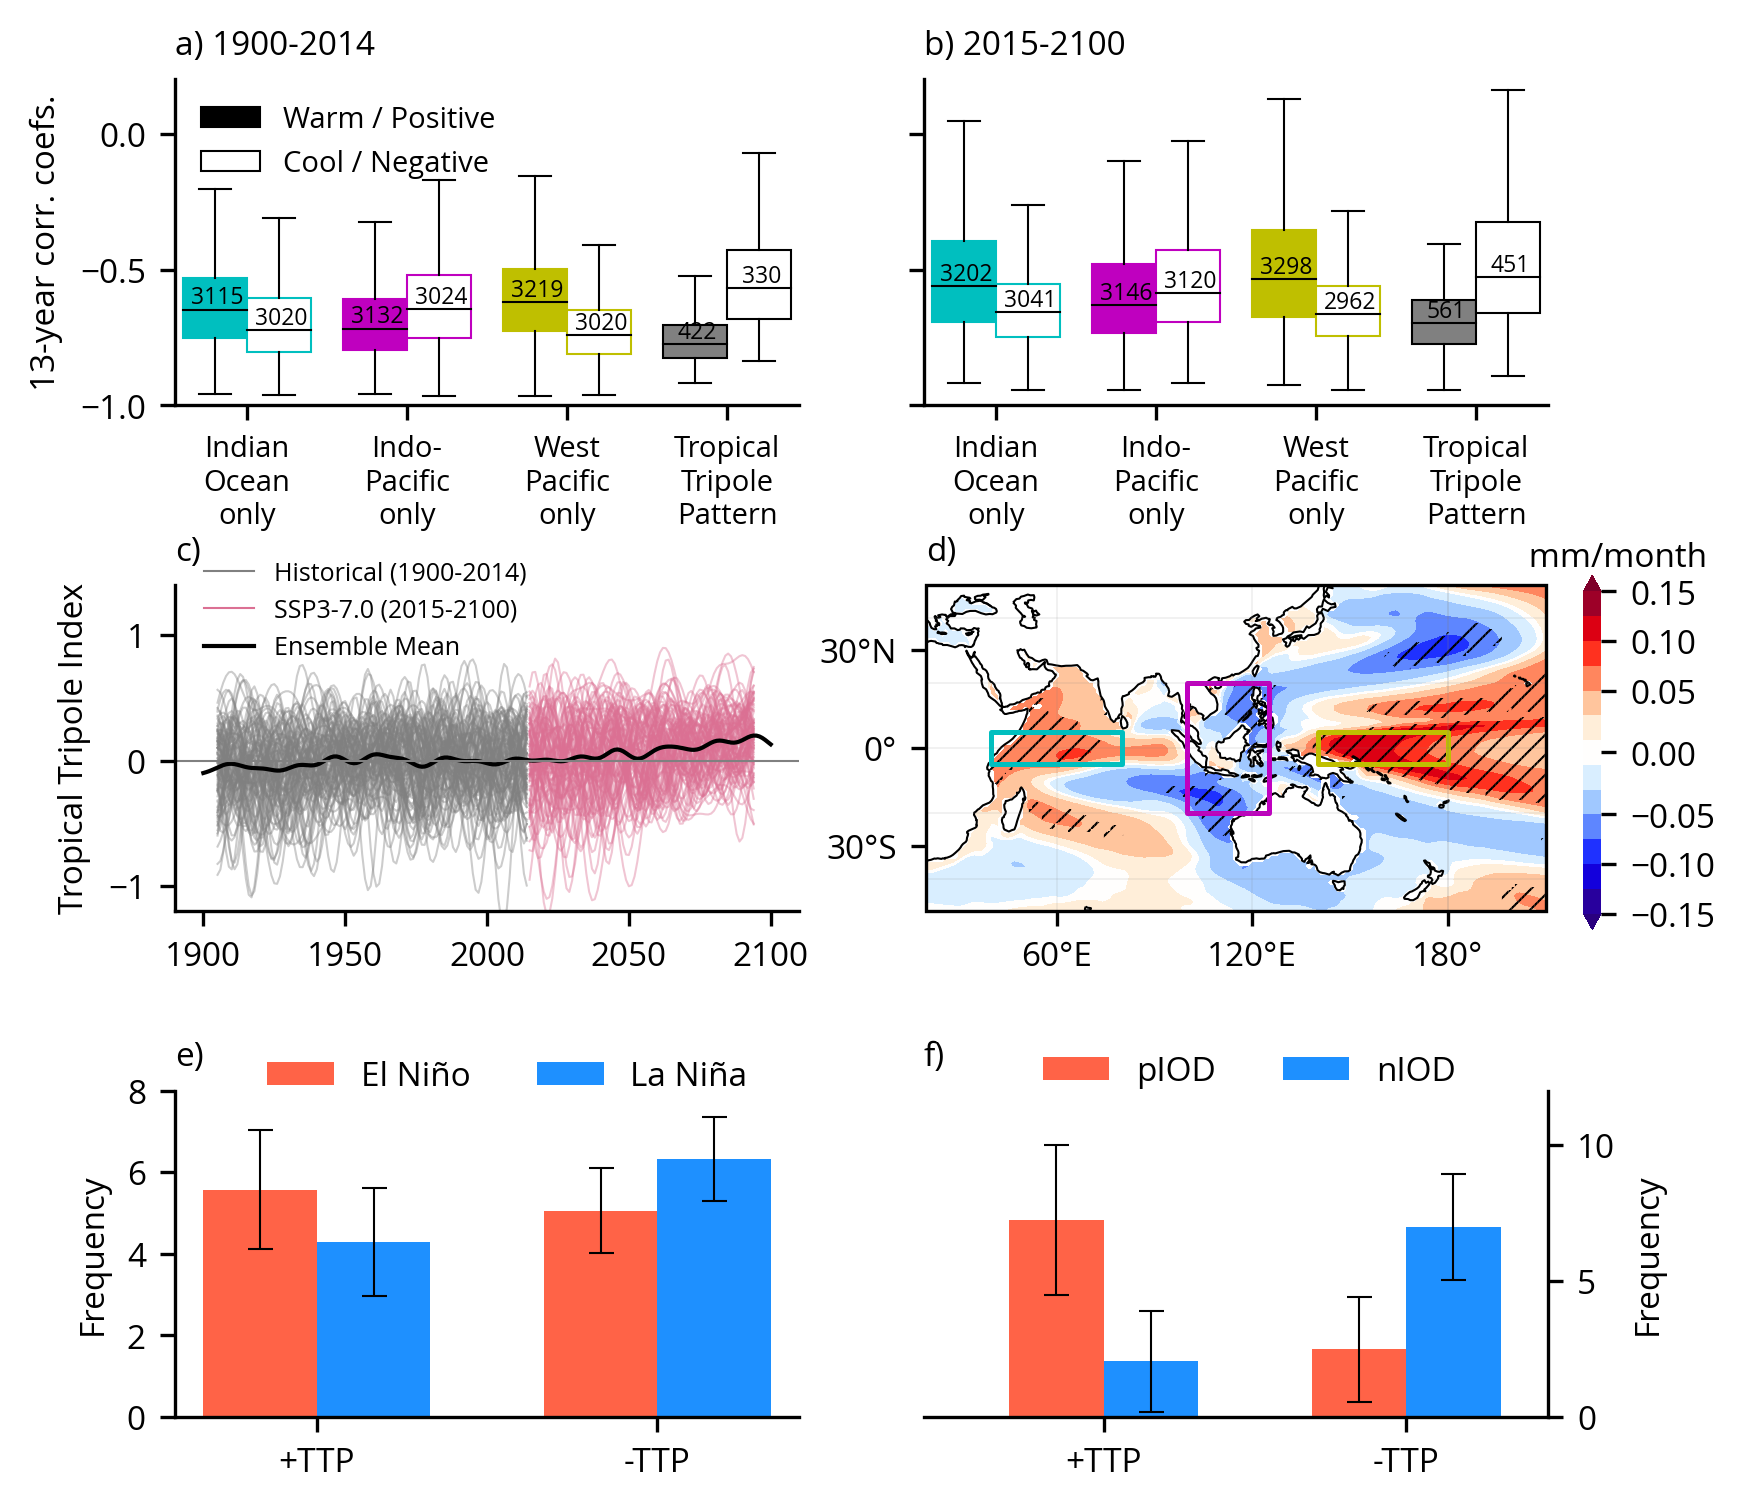

In [25]:
%matplotlib inline 

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth


utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15 
fig_height_cm = 15
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54


fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)
gs1 = GridSpec(3, 2, hspace=0.55, wspace=0.2)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[1, 0])
ax4 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax5 = fig.add_subplot(gs1[2, 0])
ax6 = fig.add_subplot(gs1[2, 1])

#fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

#ax1 = fig.add_subplot(221)
#ax2 = fig.add_subplot(222)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224,  projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 3a ##############
ylabel = '13-year corr. coefs.'

plot_boxplots(paired_data, ax=ax1, ylabel=ylabel, legend=True)
ax1.set_ylim(-1,0.2)
#ax1.axhline(0, color='grey', linewidth=0.5)

############## Figure 3b ##############
ylabel = None

plot_boxplots(paired_data2, ax=ax2, ylabel=ylabel)
ax2.set_ylim(-1,0.2)
ax2.set_yticklabels([])

#ax2.axhline(0, color='grey', linewidth=0.5)

############## Figure 3c ##############
interbasin_index_truncated = interbasin_index.sel(time=slice(str(1913),str(2087)))
plot_interbasin_index(interbasin_index, ax3)

############## Figure 3d ##############
plot_regression(reg_mean, mask, ax4)
#ax4.spines['geo'].set_visible(False)

############## Figure 3e ##############
plot_barplot(ax5, 'EN_Frequency', 'LN_Frequency', 'El Niño', 'La Niña', loc='upper center')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.set_ylim(0,8)
ax5.legend(bbox_to_anchor=(0.1,0.9), frameon=False, ncol=2)

############## Figure 3f ##############
plot_barplot(ax6, 'pIOD_Frequency', 'nIOD_Frequency', 'pIOD', 'nIOD', x=np.array([0.4, 1.2]), width=0.25, loc='upper center')

ax6.yaxis.set_ticks_position('right')  # Set ticks to the right side
ax6.yaxis.set_label_position('right')  # Set the y-label to the right side
ax6.spines['top'].set_position(('axes', 1.0))  # Move right spine to right
ax6.spines['left'].set_color('none')  # Hide the left spine
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.set_ylim(0,12)
ax6.legend(bbox_to_anchor=(0.9,1.2), frameon=False, ncol=2)



# Set subplot labels
titles = ["a) 1900-2014", "b) 2015-2100", "c)", "d)", "e)", "f)"]
for i, (ax, title) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], titles)):
    ax.set_title(title, loc="left", fontsize=8)

plt.savefig("Fig3.png")
